Import Dependencies

In [112]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Read census data into data-frame

In [79]:
df = pd.read_csv('census_data.csv') 
df.rename(columns={'   South Asian': 'South Asian'}, inplace=True)

In [80]:
df.head() 

,Neighbourhood,Neighbourhood Id,Total Population,South Asian,After-Tax Household Income
0,West Humber-Clairville,1,33312,13920,59703
1,Mount Olive-Silverstone-Jamestown,2,32954,11095,46986
2,Thistletown-Beaumond Heights,3,10360,2555,57522
3,Rexdale-Kipling,4,10529,1420,51194
4,Elms-Old Rexdale,5,9456,840,49425


Read geographical data into data-frame

In [81]:
df_lat_long = pd.read_csv("https://cocl.us/Geospatial_data")

Merge dataframes

In [ ]:
df2 = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
df2 = df2[df2.Borough!='Not assigned']
df2 = pd.merge(df2, df_lat_long, left_on='Postcode', right_on='Postal Code').drop(['Postal Code', 'Postcode', 'Borough'], axis=1)
df2 = pd.merge(df2, df, on='Neighbourhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df2.drop(['Neighbourhood Id'], axis=1, inplace=True)
df2.head()

Calculate ratios of South Asians with respect to the total population  

In [83]:
df2['Percentage of South Asian'] = df2['South Asian'] / df2['Total Population'] * 100
df2.drop(['Total Population', 'South Asian'], axis=1, inplace=True)
df2.head()

,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian
0,Victoria Village,43.725882,-79.315572,43743.0,17.047401
1,Rouge,43.806686,-79.194353,72784.0,43.390829
2,Malvern,43.806686,-79.194353,53425.0,39.879892
3,Highland Creek,43.784535,-79.160497,87321.0,36.137346
4,Flemingdon Park,43.725900,-79.340923,43511.0,34.878950


Creating a Folium Map

In [84]:
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighbourhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto


Connecting to FourSquare API

In [85]:
CLIENT_ID = 'FT1VZMOFZALEODEIWKGLPLEJQ5LFMXUCPJZWUGTVUFFO1UJ3' # your Foursquare ID
CLIENT_SECRET = 'ZZ4SGNYGLHNCMBGM0V3FS5NNNLK1WCOPDA2FGBH53NVS0LJF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Making the API request

In [86]:
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

In [87]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
  venues_list = []
  for name, lat, lng in zip(names, latitudes, longitudes):
    print(name)

    #create the API request url
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius,
        LIMIT
    )

    # make the GET request
    results = requests.get(url).json()['response']['groups'][0]['items']

    # return only relevant information for each nearby venue
    venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results
        ])
  
  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = ['Neighbourhood',
                           'Neighbourhood Latitude',
                           'Neighbourhood Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

  return(nearby_venues)

In [65]:
venues = getNearbyVenues(names=df2['Neighbourhood'],
                                 latitudes=df2['Latitude'],
                                 longitudes=df2['Longitude'])

venues

Victoria Village
Rouge
Malvern
Highland Creek
Flemingdon Park
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Ionview
Kennedy Park
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Weston
Dorset Park
Forest Hill North
Willowdale West
Roncesvalles
Agincourt North
Milliken
New Toronto
Alderwood
Long Branch


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Aga Khan Museum,43.725105,-79.332076,History Museum
2,Victoria Village,43.725882,-79.315572,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
3,Victoria Village,43.725882,-79.315572,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
4,Victoria Village,43.725882,-79.315572,Jatujak,43.736208,-79.307668,Thai Restaurant
...,...,...,...,...,...,...,...
1818,Long Branch,43.602414,-79.543484,The Beer Store,43.594755,-79.533663,Beer Store
1819,Long Branch,43.602414,-79.543484,Etobicoke Creek Trail,43.594450,-79.545855,Trail
1820,Long Branch,43.602414,-79.543484,Mr.Sub,43.593191,-79.537885,Restaurant
1821,Long Branch,43.602414,-79.543484,Connorvale Park,43.607201,-79.530702,Park


In [88]:
venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt North,74,74,74,74,74,74
Alderwood,44,44,44,44,44,44
Bathurst Manor,40,40,40,40,40,40
Bayview Village,15,15,15,15,15,15
Cliffcrest,43,43,43,43,43,43
Dorset Park,56,56,56,56,56,56
Flemingdon Park,83,83,83,83,83,83
Forest Hill North,100,100,100,100,100,100
Guildwood,32,32,32,32,32,32


One hot encoding the data

In [89]:
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')

toronto_onehot['Neighbourhood'] = venues['Neighbourhood']

cols = list(toronto_onehot)
cols.insert(0, cols.pop(cols.index('Neighbourhood')))
toronto_onehot = toronto_onehot.ix[:,cols]
toronto_onehot

/Users/raghav/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/Users/raghav/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1819,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1820,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1821,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped = toronto_grouped[['Neighbourhood', 'Indian Restaurant']]
toronto_grouped.set_index('Neighbourhood', inplace=True)

Visualizing the density of indian restaurants based on neighbourhood

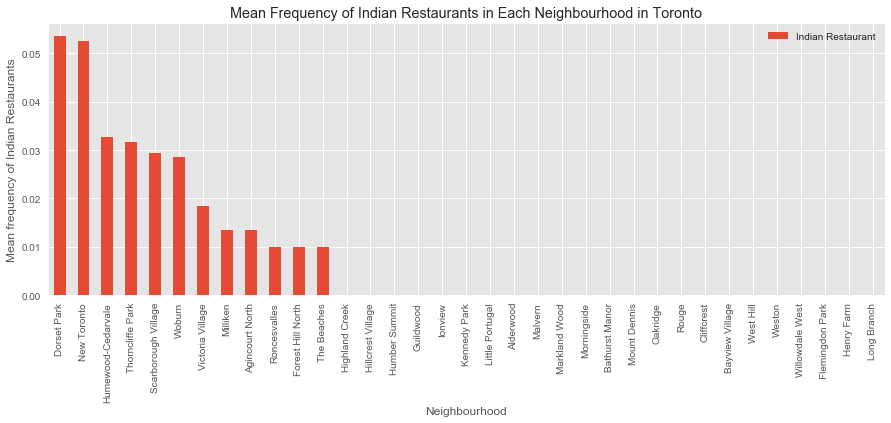

In [124]:
toronto_grouped.sort_values(by='Indian Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')
toronto_grouped.plot(kind='bar', figsize=(15,5))

plt.title('Mean Frequency of Indian Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Indian Restaurants')

plt.show()

Visualizing the density of South Asians given a neighbourhood

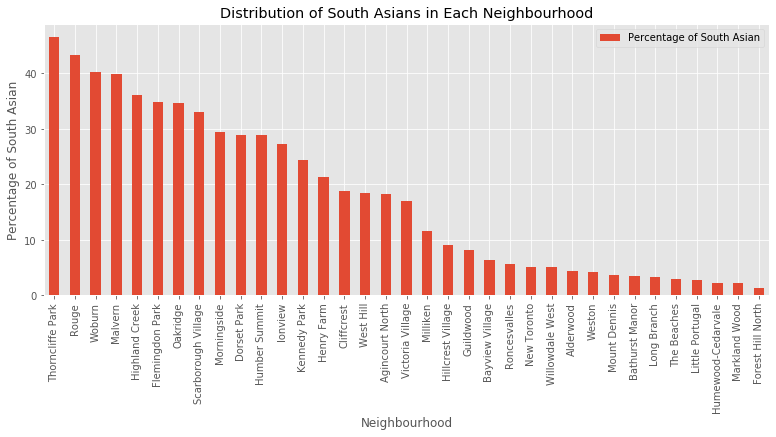

In [93]:
df_ethnic = df2[['Neighbourhood', 'Percentage of South Asian']].set_index('Neighbourhood')

df_ethnic.sort_values(by='Percentage of South Asian', ascending=False, inplace=True)

df_ethnic.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of South Asians in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Percentage of South Asian')

plt.show()

Visualizing distribution of after-tax income based off  neighbourhood

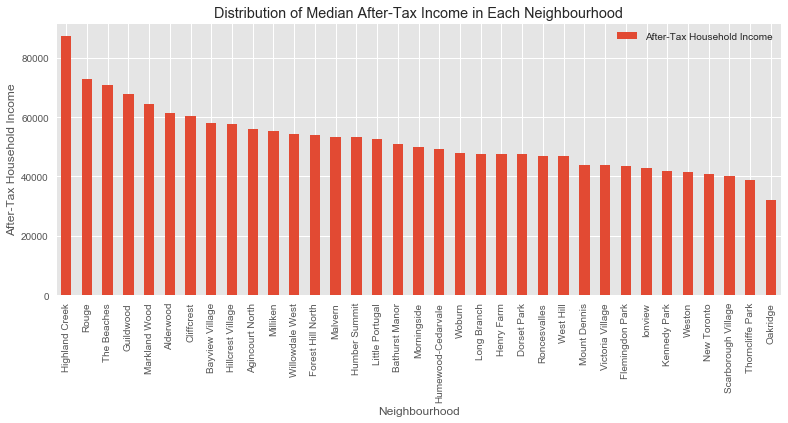

In [125]:
df_income = df2[['Neighbourhood', 'After-Tax Household Income']].set_index('Neighbourhood')

df_income.sort_values(by='After-Tax Household Income', ascending=False, inplace=True)

df_income.plot(kind='bar', figsize=(13,5))
plt.title('Distribution of Median After-Tax Income in Each Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('After-Tax Household Income')

plt.show()

In [97]:
df = pd.merge(df2, toronto_grouped, on='Neighbourhood')
df.head()

,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant
0,Victoria Village,43.725882,-79.315572,43743.0,17.047401,0.018519
1,Rouge,43.806686,-79.194353,72784.0,43.390829,0.000000
2,Malvern,43.806686,-79.194353,53425.0,39.879892,0.000000
3,Highland Creek,43.784535,-79.160497,87321.0,36.137346,0.000000
4,Flemingdon Park,43.725900,-79.340923,43511.0,34.878950,0.000000


In [99]:
X = df.values[:,3:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.76318401, -0.05420249,  0.66089666],
       [ 1.89181483,  1.7897289 , -0.58350531],
       [ 0.12196797,  1.54397777, -0.58350531],
       [ 3.22082273,  1.28201495, -0.58350531],
       [-0.78439402,  1.19393239, -0.58350531],
       [-0.25953784, -1.09152496,  1.60772425],
       [ 1.11591265, -1.09491053, -0.58350531],
       [ 1.4250119 , -0.67220943, -0.58350531],
       [-0.18484571,  0.81974391, -0.58350531],
       [-0.48343137,  0.0455518 , -0.58350531],
       [ 1.72478605, -1.03811505,  0.08847175],
       [-0.38240958,  1.57214621,  1.33642916],
       [ 0.51115327, -0.61709889, -0.58350531],
       [-0.09278332, -1.00491438, -0.58350531],
       [-1.22925557,  2.01723333,  1.53852753],
       [-1.08883072,  1.06286568,  1.39289782],
       [-0.40517377,  0.25058523, -0.58350531],
       [ 0.03913925, -1.04725646, -0.58350531],
       [-0.83376213,  0.66651952, -0.58350531],
       [-0.94301194,  0.45513002, -0.58350531],
       [ 0.54278543, -0.80253356, -0.583

In [102]:
df_normal = pd.DataFrame(Clus_dataSet)
df_normal.rename(columns={0:'Household Income', 1:'% South Asian', 2:'No. of Indian Restaurants'}, inplace=True)
df_normal.head()

,Household Income,% South Asian,No. of Indian Restaurants
0,-0.763184,-0.054202,0.660897
1,1.891815,1.789729,-0.583505
2,0.121968,1.543978,-0.583505
3,3.220823,1.282015,-0.583505
4,-0.784394,1.193932,-0.583505


Plotting squared error as a function of different K values to find optimum K value

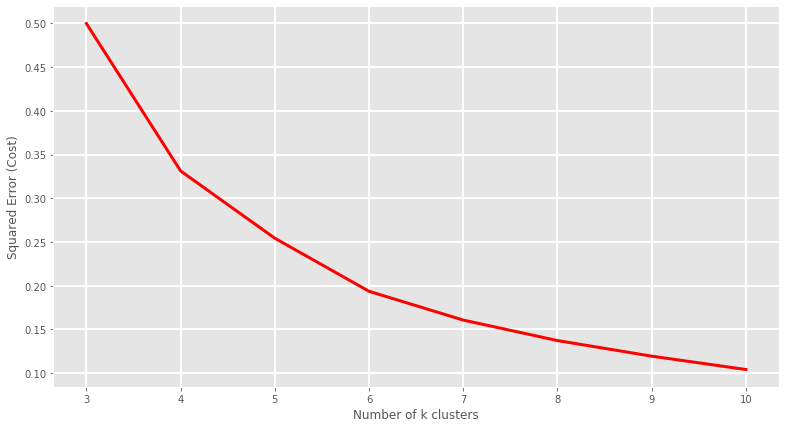

In [103]:
error_cost=[]

for i in range(3, 11):
  KM = KMeans(n_clusters=i, max_iter=100)
  try:
    KM.fit(df_normal)

  except ValueError:
    print('Error on line', i)

  # calculate squared error for the clustered points
  error_cost.append(KM.inertia_ / 100)

# plot the K values against the squared error cost
plt.figure(figsize=(13,7))
plt.plot(range(3,11), error_cost, color='r', linewidth=3)
plt.xlabel('Number of k clusters')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)

plt.show()

Elbow @ K=6 so you should use 6 clusters

In [109]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_normal)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 4, 1, 4, 1, 2, 5, 5, 1, 1], dtype=int32)

In [110]:
df_normal.drop(['Household Income', '% South Asian'], axis=1, inplace=True)
df_clustered = pd.merge(df, df_normalized, left_index=True, right_index=True)
df_clustered.insert(0, 'Cluster Label', kmeans.labels_)

In [115]:
# create map
clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Neighbourhood'], df_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusters)
       
clusters

Analyze the different clusters

In [126]:
df_clustered.loc[df_clustered['Cluster Label'] == 0]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
0,0,Victoria Village,43.725882,-79.315572,43743.0,17.047401,0.018519,-0.763184,-0.054202,0.660897
13,0,Bathurst Manor,43.754328,-79.442259,51076.0,3.465003,0.000000,-0.092783,-1.004914,-0.583505
17,0,Little Portugal,43.647927,-79.419750,52519.0,2.860081,0.000000,0.039139,-1.047256,-0.583505
24,0,Mount Dennis,43.691116,-79.476013,43790.0,3.751931,0.000000,-0.758887,-0.984831,-0.583505
25,0,Weston,43.706876,-79.518188,41356.0,4.251890,0.000000,-0.981409,-0.949836,-0.583505
27,0,Forest Hill North,43.696948,-79.411307,53978.0,1.327503,0.010000,0.172525,-1.154531,0.088472
28,0,Willowdale West,43.782736,-79.442259,54226.0,5.077940,0.000000,0.195197,-0.892015,-0.583505
29,0,Roncesvalles,43.648960,-79.456325,46883.0,5.576332,0.010000,-0.476118,-0.857130,0.088472
30,0,Agincourt North,43.815252,-79.284577,55893.0,18.256449,0.013514,0.347599,0.030426,0.324572
31,0,Milliken,43.815252,-79.284577,55464.0,11.591149,0.013514,0.308378,-0.436118,0.324572


In [117]:
df_clustered.loc[df_clustered['Cluster Label'] == 1]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
2,1,Malvern,43.806686,-79.194353,53425.0,39.879892,0.0,0.121968,1.543978,-0.583505
4,1,Flemingdon Park,43.725900,-79.340923,43511.0,34.878950,0.0,-0.784394,1.193932,-0.583505
8,1,Morningside,43.763573,-79.188711,50069.0,29.533085,0.0,-0.184846,0.819744,-0.583505
9,1,West Hill,43.763573,-79.188711,46803.0,18.472547,0.0,-0.483431,0.045552,-0.583505
16,1,Henry Farm,43.778517,-79.346556,47659.0,21.401768,0.0,-0.405174,0.250585,-0.583505
18,1,Ionview,43.727929,-79.262029,42971.0,27.344036,0.0,-0.833762,0.666520,-0.583505
19,1,Kennedy Park,43.727929,-79.262029,41776.0,24.324009,0.0,-0.943012,0.455130,-0.583505
21,1,Oakridge,43.711112,-79.284577,32079.0,34.669556,0.0,-1.829535,1.179276,-0.583505
22,1,Humber Summit,43.756303,-79.565963,53272.0,28.914304,0.0,0.107980,0.776432,-0.583505


In [127]:
df_clustered.loc[df_clustered['Cluster Label'] == 2]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
5,2,Humewood-Cedarvale,43.693781,-79.428191,49252.0,2.227637,0.032609,-0.259538,-1.091525,1.607724
26,2,Dorset Park,43.757410,-79.273304,47630.0,28.976523,0.053571,-0.407825,0.780787,3.016372
32,2,New Toronto,43.605647,-79.501321,40859.0,5.146995,0.052632,-1.026846,-0.887182,2.953216


In [128]:
df_clustered.loc[df_clustered['Cluster Label'] == 3]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
11,3,Woburn,43.770992,-79.216917,47908.0,40.282322,0.028571,-0.382410,1.572146,1.336429
14,3,Thorncliffe Park,43.705369,-79.349372,38645.0,46.641084,0.031579,-1.229256,2.017233,1.538528
15,3,Scarborough Village,43.744734,-79.239476,40181.0,33.006458,0.029412,-1.088831,1.062866,1.392898


In [129]:
df_clustered.loc[df_clustered['Cluster Label'] == 4]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
1,4,Rouge,43.806686,-79.194353,72784.0,43.390829,0.0,1.891815,1.789729,-0.583505
3,4,Highland Creek,43.784535,-79.160497,87321.0,36.137346,0.0,3.220823,1.282015,-0.583505


In [130]:
df_clustered.loc[df_clustered['Cluster Label'] == 5]

,Cluster Label,Neighbourhood,Latitude,Longitude,After-Tax Household Income,Percentage of South Asian,Indian Restaurant,Household Income,% South Asian,No. of Indian Restaurants
6,5,Markland Wood,43.643515,-79.577201,64297.0,2.179269,0.00,1.115913,-1.094911,-0.583505
7,5,Guildwood,43.763573,-79.188711,67678.0,8.218211,0.00,1.425012,-0.672209,-0.583505
10,5,The Beaches,43.676357,-79.293031,70957.0,2.990680,0.01,1.724786,-1.038115,0.088472
12,5,Hillcrest Village,43.803762,-79.363452,57682.0,9.005551,0.00,0.511153,-0.617099,-0.583505
20,5,Bayview Village,43.786947,-79.385975,58028.0,6.356328,0.00,0.542785,-0.802534,-0.583505
23,5,Cliffcrest,43.716316,-79.239476,60384.0,18.826483,0.00,0.758177,0.070326,-0.583505
33,5,Alderwood,43.602414,-79.543484,61402.0,4.479841,0.00,0.851245,-0.933880,-0.583505
